# Finding Lane Lines on the Road

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from moviepy.editor import VideoFileClip
import cv2

### Introduction
Finding Lane Lanes in the road is the first step towards the development of autonomous vehicle systems. Image/Video captured using a camera mounted in the vehicle has to be processed to detect lines. Image processing and Machine Learning concepts have to be effectively blended to develop such a solution. The current project "Third Eye 1.0" is an attempt to build basic lane line finding system. 

### Data Analysis
To develop the basic functionality six images and three video files are supplied. The images are examples of different lane line pattern in daylight condition. The lane lines are either solid yellow/white in one side and dotted lines on the other side. There is one image with the line in a curve too. Among the three videos, one video (challenge.mp4) is an example of a curve and slight adverse condition such as shade in the road. The shade slightly affects the color pattern in the lane line (or technically contributes to noise). While developing the system these conditions has to be taken care with the help of image processing techniques. 

### Building the Base System
From the data analysis, we found that the lane lines, our primary target from the image is either yellow or white; color filtering is the first task.

#### Color Filtering

The first step in color filtering is converting the image from RGB/BGR to HLS (Hue Lightness Saturation) color representation. Then find the pixels falling in the range of yellow and white. The pixel ranges used in the implementation is,

White : np.uint8([20,200,0]), np.uint8([255,255,255])

Yellow : np.uint8([10,50,100]), np.uint8([100,255,255])

After the yellow and white pixels are filtered, the result will be combined using bitwise_or API in OpenCV. Then the combined result is joined with the original image with bitwise_and. Now the resulting image will only have white and yellow pixels. 

Let's see the code examples and results.

In [2]:
def select_colors(img):
    hls_filtered = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    white_pix = cv2.inRange(hls_filtered, np.uint8([20,200,0]), np.uint8([255,255,255]))
    yellow_pix = cv2.inRange(hls_filtered, np.uint8([10,50,100]), np.uint8([100,255,255]))
    combined_images = cv2.bitwise_or(white_pix, yellow_pix)
    ywimg = cv2.bitwise_and(img, img, mask = combined_images)
        
    return ywimg

def plot_img(image, cmp = None):
    """
    Utility to plot image
    """
    #cmap='gray'
    if cmp != None:
        plt.imshow(image)
        plt.show()
    else:
        plt.imshow(image,cmap=cmp)
        plt.show()

In [3]:
image = mpimg.imread("test_images/solidYellowLeft.jpg")

In [4]:
yw_image = select_colors(image)

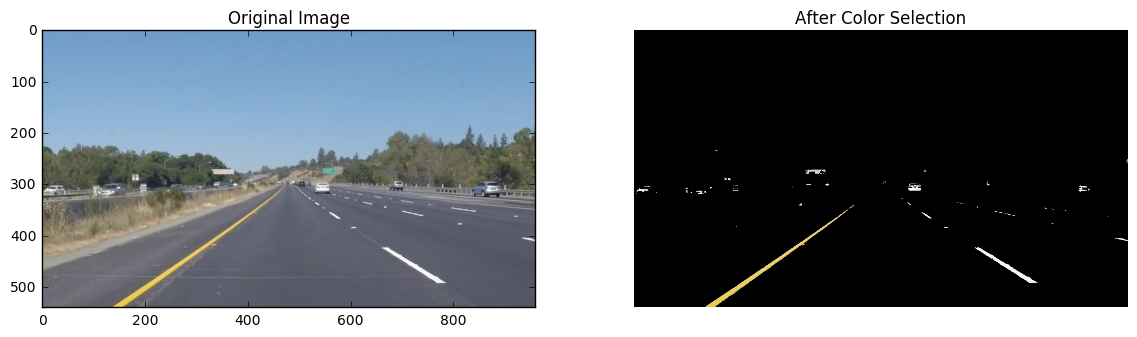

In [5]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(yw_image)
axs[1].set_title("After Color Selection")

#### Edge Detection
After the color selection, we can proceed to edge detection. Canny's method implemented in OpenCV is used to extract the edges. Before the edges are identified we have to apply Gaussian Blur to the image. Canny algorithm expects two parameters low_threshod and high_threshold. We are adopting an automated method to detect these threshold values. The Gaussian Blur image is processed with Otsu threshold algorithm. Otsu's thresholding method involves iterating through all the possible threshold values and calculating a measure of spread for the pixel levels each side of the threshold, i.e. the pixels that either fall in foreground or background. The aim is to find the threshold value where the sum of foreground and background spreads is at its minimum. To get this first we will transform the image to grayscale and applied otsu thresholding. It returns the high_threshold value. Now the low_threshod value is calculated by "0.5 * high_threshold". This value is now supplied to canny for edge detection.

Let's walk through the code now. 

#### Gray Scaling the Image

In [6]:
def togrey(img):
    """
    Concery image to gray
    """
    gimg = cv2.cvtColor(img,cv2.COLOR_RGBA2GRAY)
        
    return gimg

In [7]:
gim = togrey(yw_image)

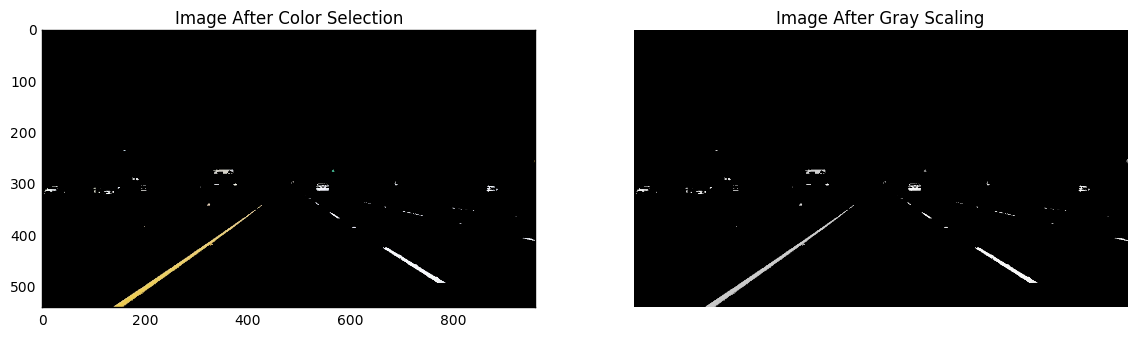

In [8]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(yw_image)
axs[0].set_title("Image After Color Selection")
axs[1].imshow(gim,cmap='gray')
axs[1].set_title("Image After Gray Scaling")

#### Applying Gaussian Blur

In [9]:
kernel_size = 17

def gaussian_blur(img):
    """
        Apply Gaussian Smoothing in the image
        TODO : Find the kernel size aut0matically
    """
    gsimg = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)
        
    return gsimg

In [10]:
gbimg = gaussian_blur(gim)

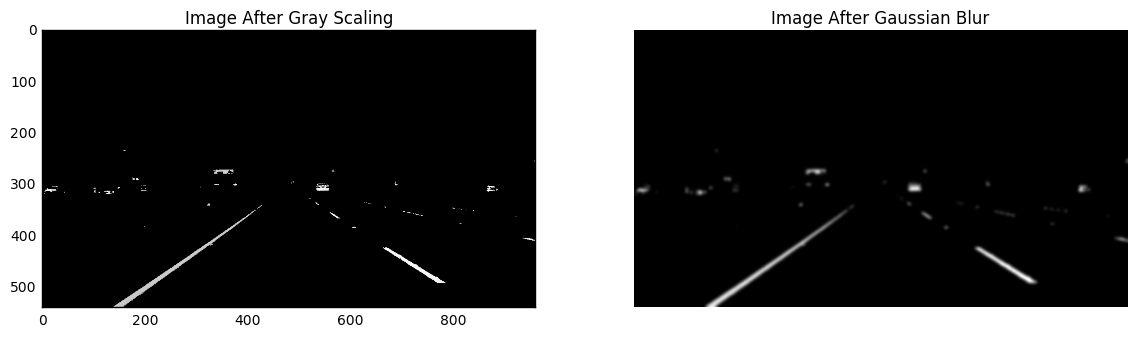

In [11]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(gim,cmap='gray')
axs[0].set_title("Image After Gray Scaling")
axs[1].imshow(gbimg,cmap='gray')
axs[1].set_title("Image After Gaussian Blur")

The Gaussian Blur required a parameter kernel size. As a next step automatic estimation of the kernel size has to be done.

#### Find low_/high_threshold for Canny with Otsu Threshold

In [12]:
def get_canny_thresh_ott(img):
    """
    Find the otsu threshold from gray scale image. The threshold value can then used 
    for determing the low and high threshold in canny edge.
    """
        
    high_thresh, image_tresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
        
    return (high_thresh,low_thresh)

In [13]:
otsu_thesh = get_canny_thresh_ott(gbimg)
print otsu_thesh

(59.0, 29.5)


#### Canny Edge Detection

In [14]:
def canny_transform(img):
    """
    Apply Canny edge detector in the image
    """
    cimg = cv2.Canny(img, otsu_thesh[1], otsu_thesh[0])
    return cimg

In [15]:
canny_edges = canny_transform(gbimg)

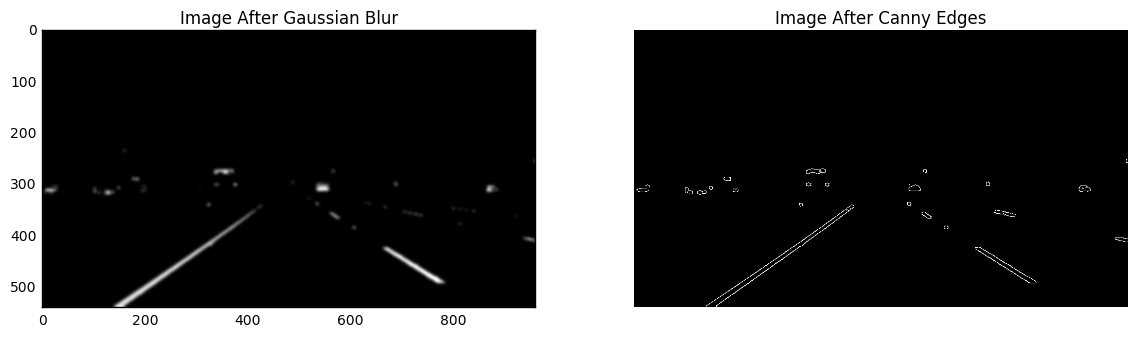

In [16]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(gbimg,cmap='gray')
axs[0].set_title("Image After Gaussian Blur")
axs[1].imshow(canny_edges,cmap='gray')
axs[1].set_title("Image After Canny Edges")

Now the line edges are detected by the Canny Edge algorithm. from the resulted image we can see that the lane lines and other visible edges are marked properly. Now we have to mask/separate the region where the lane lines are available. This will help us to avoid the edges detected in the traffic signs or other vehicle parts available in the image after the color selection. 

Let's see the code in action.

#### Finding the Region of Interest

In [17]:
shape = image.shape
vertices = np.array([[(100,shape[0]),(shape[1]*.45, shape[0]*0.6),\
(shape[1]*.55, shape[0]*0.6), (shape[1],shape[0])]], dtype=np.int32)

def get_roi(img,vertices):
    """
    Apply region of intrerest mask in an image based on supplied vertices.
    TODO : Automatic vertices determination ?
    """
        
    image_mask = np.zeros_like(img)
        
    if len(img.shape) > 2:
        channels = img.shape[2]
        mask_ignore = (255,) * channels
    else:
        mask_ignore = 255
        
    cv2.fillPoly(image_mask, vertices, mask_ignore)

    roi_img = cv2.bitwise_and(img,image_mask)
        
    return roi_img

In [18]:
roi_img = get_roi(canny_edges,vertices)

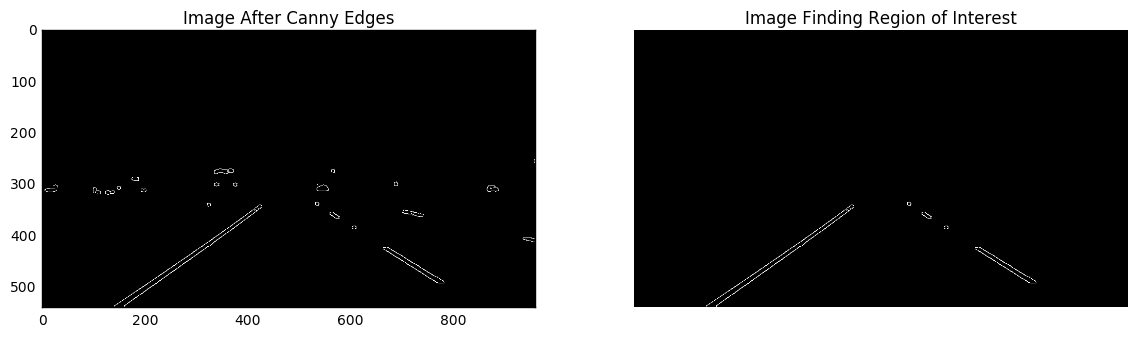

In [19]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(canny_edges,cmap='gray')
axs[0].set_title("Image After Canny Edges")
axs[1].imshow(roi_img,cmap='gray')
axs[1].set_title("Image Finding Region of Interest")

If we inspect the resulted image only the lane line canny edges are available there.  Now we may wonder is this the moment we waited to get the lane line? No, we just finished the baby step towards the same. In this step, we supplied a parameter called vertices. To support different camera position or view an automated vertices detection can be added. This will be a challenging problem to hack next !!!

Now let's proceed to make our line detection more robust. In this step, we will use Probabilistic Hough Transformation to detect the lane lanes. The canny edges result will be used as input for the hough transformation. As like Canny, Hough Transformation also requires a set of parameters. Automatic learning of such parameters will be exciting next step in this journey. 

#### Hough Transformation

In [20]:
rho = 1
theta = np.pi/180
threshold = 15
min_line_len = 25
max_line_gap = 250


def hough_transform(img,rho,theta,threshold,min_line_len,max_line_gap):
    """
    Apply Hough Transform in an image
    """
        
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),\
    minLineLength=min_line_len, maxLineGap=max_line_gap)
        
    return lines

def draw_lines(img, lines, color=[0, 255, 0], thickness=2):
    """
    TODO : Improve here from the template
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

In [21]:
houghline = hough_transform(roi_img,rho,theta,threshold,min_line_len,max_line_gap)

In [22]:
copy_img = np.copy(image)
line_orig = draw_lines(copy_img, houghline)

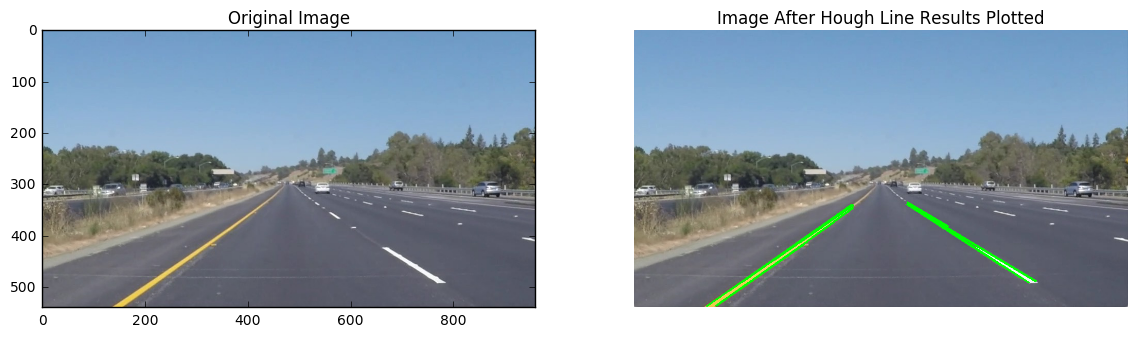

In [23]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(line_orig,cmap='gray')
axs[1].set_title("Image After Hough Line Results Plotted")

If we closely inspect the resulted image that there are multiple lines marked after the result of Hough Transform. This has some potential impact on autonomous vehicles. When we are trying to estimate the driving angle multiple lane lines may cause confusion for the estimator. So we have to fit a smooth line. in the image. We are going to apply the typical line equation y = mx +b in the Hough Line results to make the lines smooth. 

#### Fitting Smooth Line

In [24]:
trap_bottom_width = 0.85 
trap_top_width = 0.07
trap_height = 0.4 


    
def draw_lines_h(img, lines, color=[0, 255, 0], thickness=10):
    
    # In case of error, don't draw the line
    draw_right = True
    draw_left = True
    
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
        
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    

    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    

    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
    
    return img

In [25]:
copy_img2 = np.copy(image)
line_orig_smooth = draw_lines_h(copy_img2, houghline)

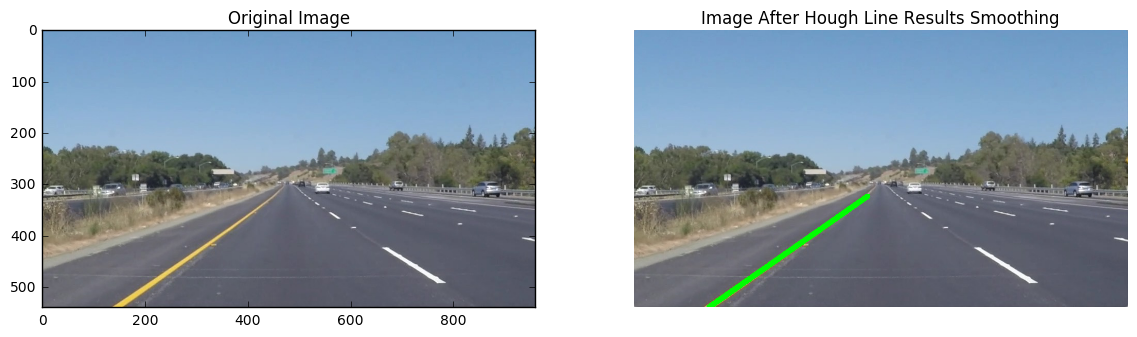

In [26]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
plt.axis('off')
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(line_orig_smooth)
axs[1].set_title("Image After Hough Line Results Smoothing")

### Building a Pipeline for Lane Line Annotation
Now we have built the basic functionality. Let's make it as a pipeline for re-use. I have created a package called "thirdeye" from this code, which includes a pipeline to process image and video. Let's see the package in action. First, we are testing the image pipeline.

In [27]:
from thirdeye import Pipeline
impipe = Pipeline()

In [28]:
import glob
images = glob.glob("test_images/*.jpg")
processed_img = list()

In [29]:
for img in images:
    np_img = mpimg.imread(img)
    frm = impipe.fit_frame(np_img)
    processed_img.append(frm)

Now we have processed all the test images with the pipline. Let's explore the results.

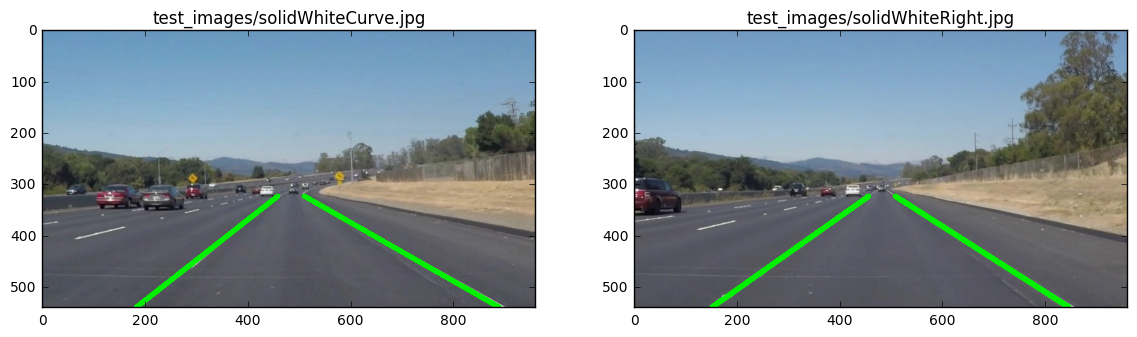

In [30]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
axs[0].imshow(processed_img[0])
axs[0].set_title(images[0])
axs[1].imshow(processed_img[1])
axs[1].set_title(images[1])

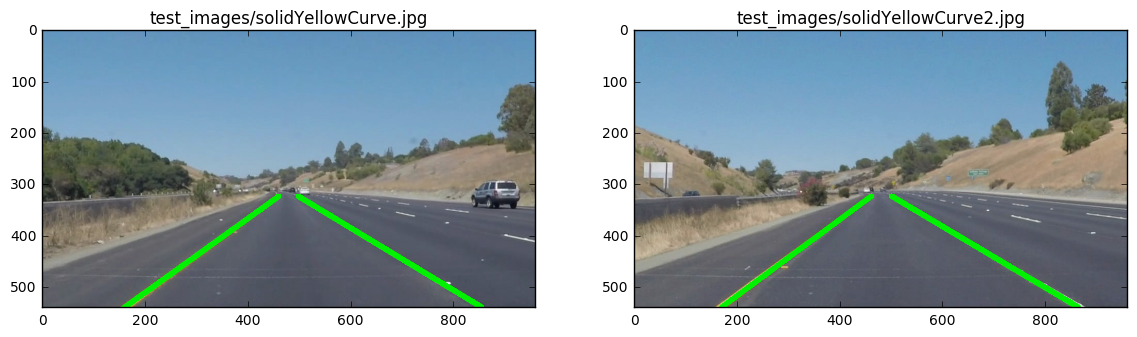

In [31]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
axs[0].imshow(processed_img[2])
axs[0].set_title(images[2])
axs[1].imshow(processed_img[3])
axs[1].set_title(images[3])

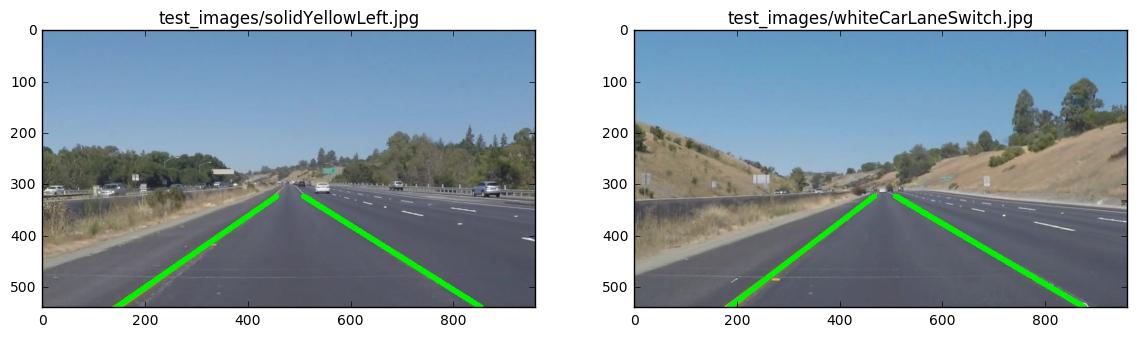

In [32]:
fig, axs = plt.subplots(1,2,figsize=(14, 18))
axs[0].imshow(processed_img[4])
axs[0].set_title(images[4])
axs[1].imshow(processed_img[5])
axs[1].set_title(images[5])

## Optional Challenge Video Processing 
As part of the project, an optional challenge of processing video is provided. We have created a video processing pipeline. Let's try the results of video processing.

Let's see the code in action

In [33]:
videos = glob.glob("test_videos/*.mp4")
outpath = "notebook_vid_res/"

In [34]:
for video in videos:
    processed_video = impipe.fit_vid(video)
    outfile = outpath + video.split("/")[-1]
    processed_video.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video notebook_vid_res/challenge.mp4
[MoviePy] Writing video notebook_vid_res/challenge.mp4


100%|██████████| 251/251 [00:56<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: notebook_vid_res/challenge.mp4 

[MoviePy] >>>> Building video notebook_vid_res/solidWhiteRight.mp4
[MoviePy] Writing video notebook_vid_res/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:28<00:00,  7.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: notebook_vid_res/solidWhiteRight.mp4 

[MoviePy] >>>> Building video notebook_vid_res/solidYellowLeft.mp4
[MoviePy] Writing video notebook_vid_res/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:26<00:00,  7.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: notebook_vid_res/solidYellowLeft.mp4 



I have uploaded the resulting videos to Youtube. Lets play the results here !!!

In [35]:
from IPython.display import YouTubeVideo

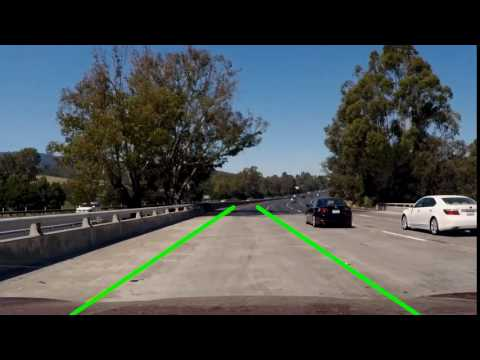

In [36]:
YouTubeVideo("aL_uIito0_4")

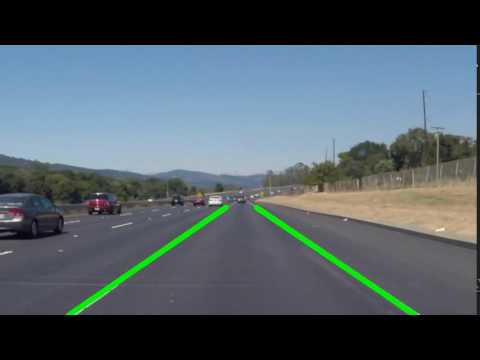

In [37]:
YouTubeVideo("Lw47Zfltjro")

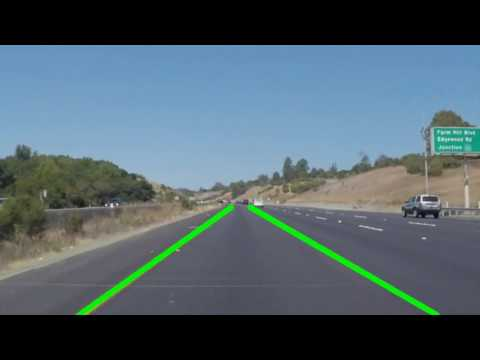

In [38]:
YouTubeVideo("M5zzMs5xLF8")

### Results and Next Steps
If we closely observe the video we can see a jitter in the line marking. it is happening because the line context of the previous frame is not properly integrated to the next one. We may have to adopt averaging techniques to make it happen. This will be a key enhancement to the project. 

All the images and videos we tested is under normal or slightly challenging conditions. There were no images in the night-time, adverse weather such as rain or snow. This method has to be tested and enhanced by such conditions to verify the feasibility to impute in the brain of an autonomous vehicle. 

Happy Vehicle Hacking!!